In [1]:
import torch
import open3d as o3d
import os
import os.path as osp
import numpy as np
import struct
import open3d
import mayavi.mlab
from tkinter import NONE
from typing import NoReturn
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.utils.geometry_utils import view_points
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import time


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def show_dep_comp_map(map):

            plt.imshow(map)
            plt.show()


def points_vis_one(geom1):
    fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(1920, 1080))
    mayavi.mlab.points3d(geom1[:, 0], geom1[:, 1], geom1[:, 2],
                         geom1[:, 2],  # Values used for Color
                         mode="point",
                         colormap='spectral',  # 'bone', 'copper', 'gnuplot'
                         # color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                         figure=fig,
                         )
    mayavi.mlab.show()

def get_filename(depth_root):
    filename=os.listdir(depth_root)
    print(len(filename))
    return filename

In [3]:
root = "data/nuscenes/nuscenes-full/"
nusc_root = '/data/nuscenes/nuscenes-full'
nusc = NuScenes(version='v1.0-trainval', dataroot=nusc_root)
depth_root="/data/csh_test/vis_out/fsnet1/CAM_FRONT"
filename=get_filename(depth_root)
# print(images.shape)
# torch.Size([bs, 6, 3, 900, 1600])

# step 1 : lidar to pic ,get depth_map


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 31.588 seconds.
Reverse indexing ...
Done reverse indexing in 8.2 seconds.
4227


In [13]:
def process_dep_map(depth_map_dir,error_threshold = 0.8,nbr_rand=40000):
#     depth_map_dir="/data/csh_test/vis_out/fsnet1/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.png"
    depth_map=Image.open(depth_map_dir)
    depth_map=np.array(depth_map)/257
#     plt.imshow( depth_map )
#     plt.show()
    rgb_map_dir="/data/nuscenes/nuscenes-full/samples/"+depth_map_dir[30:-3]+"jpg"
    rgb_map=Image.open(rgb_map_dir)
    rgb_map=np.array(rgb_map)
#     plt.imshow( rgb_map )
#     plt.show()
    real_depth_map_dir="/data/nuscenes/rgbd__image_test/depth/samples/"+depth_map_dir[30:-3]+"png"
    real_depth_map=Image.open(real_depth_map_dir)
    real_depth_map=np.array(real_depth_map)/257

#     plt.imshow( real_depth_map )
#     plt.show()
    
    error_map=np.abs(depth_map-real_depth_map)

    mask = error_map  <= error_threshold* np.max(real_depth_map)

    # 使用掩码选择要显示的像素
    result_array = np.zeros_like(depth_map)
    result_array[mask] = depth_map[mask]

    # 将结果保存为NumPy数组
    process1_map = result_array.astype(np.uint16)

    # 随机抽取20000个索引
    indices = np.argwhere(depth_map >0)
    if len(indices) <= nbr_rand:
        # 如果小于4000的像素不足200个，可以选择全部
        selected_indices = indices
    else:
        # 否则随机抽取200个
        selected_indices = indices[np.random.choice(len(indices), size=nbr_rand, replace=False)]

    # 提取所选像素的深度值
    selected_depths = process1_map[selected_indices[:, 0], selected_indices[:, 1]]
    # 创建与深度图像相同形状的全零数组
    output_array = np.zeros_like(depth_map)

    # 将选定的像素深度值复制到输出数组中
    for idx in selected_indices:
        row, col = idx
        output_array[row, col] = process1_map[row, col]
#     plt.imshow(output_array)
#     plt.show()
    return (output_array)


    
    
    
    

In [53]:
def get_new_pcl_path(pcl_path):
    pcl_root="/data/csh_test/vis_out/fsnet1/LIDAR_TOP"
#     print(pcl_path)
    index=pcl_path.find("LIDAR_TOP/")
    if index!=-1:
        pcl_token=pcl_path[index+10:]
#         print(pcl_token)
        pcl_token=pcl_token+".pkl.npy"
        files_in_folder = os.listdir(pcl_root)
#         print(files_in_folder)
        # 检查目标文件名是否在文件列表中
        if pcl_token in files_in_folder:
#             print(f"文件夹 {pcl_root} 中包含文件 {pcl_token}。")
            pcl_full_path=os.path.join(pcl_root,pcl_token)
            pc=LidarPointCloud.from_file(pcl_path)
            pc.points=np.load(pcl_full_path)
            return pc
            
        else:
#             print(f"文件夹 {pcl_root} 中不包含文件 {pcl_token}。")
            return LidarPointCloud.from_file(pcl_path)

        
        
# pcl_path="/data/nuscenes/nuscenes-full/samples/LIDAR_TOP/n008-2018-08-22-15-53-49-0400__LIDAR_TOP__1534968255447783.pcd.bin"
# pc_new=get_new_pcl_path(pcl_path)
# pc_new.points.shape 
        
        
        
        

In [54]:

def get_sensor_from_img_filepath(depth_root, i, filename, nusc, root,camera_device):
    # print(root)
    # print(filename)
    index = filename.find("samples/")
    if (index != -1):
        filename = filename[index:]
#     print(filename)
    token = nusc.field2token('sample_data', 'filename', filename)
#     print(token)
    # samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119612404.jpg
    sample_data_token = nusc.get('sample_data', token[0])
    # print(sample_data_token)
    sample_record = nusc.get('sample', sample_data_token['sample_token'])
    pointsensor_channel = 'LIDAR_TOP'
    first_index = filename.find("/") + 1
    second_index = filename.find("/", first_index + 1)
    # print(first_index,second_index)
    if (first_index != -1 and second_index != -1):
        camera_channel = filename[first_index:second_index]
    pointsensor_token = sample_record['data'][pointsensor_channel]
    camera_token = sample_record['data'][camera_channel]
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
    print(pcl_path)
    pc=get_new_pcl_path(pcl_path)
#     if pointsensor['sensor_modality'] == 'lidar':
#         pc = LidarPointCloud.from_file(pcl_path)
#     else:
#         pc = RadarPointCloud.from_file(pcl_path)
    org_pc=pc.points[:3,:]
#     points_vis_one(org_pc.T)
#     print(org_pc.shape)
    cs_record1 = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

    poserecord1 = nusc.get('ego_pose', pointsensor['ego_pose_token'])

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord2 = nusc.get('ego_pose', cam['ego_pose_token'])

    # Fourth step: transform from ego into the camera.
    cs_record2 = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    depmap_dir=depth_root +camera_device+ "/" + i
    depth_map = Image.open(depmap_dir)
    depth_map=process_dep_map(depmap_dir,nbr_rand=20000)
#     print("##############################################")
#     print(depmap_dir)
#     print(np.sum(depth_map>0))
#     36533
#     plt.imshow(depth_map)
#     plt.show()
    # show_dep_comp_map(depth_map)
    # 定义一个转换函数，用于将图像转换为张量
    transform = transforms.ToTensor()

    # 使用转换函数将图像转换为张量
    depth_map = transform(depth_map)

    height = depth_map.shape[-2]
    width = depth_map.shape[-1]
    depth_map = depth_map.view(-1)
    nonzero_indices = torch.nonzero(depth_map).squeeze()
    depth_map = depth_map[nonzero_indices].squeeze()
    y_coords, x_coords = torch.meshgrid(torch.arange(height), torch.arange(width))
    y_coords = y_coords.reshape(-1)[nonzero_indices].squeeze()
    x_coords = x_coords.reshape(-1)[nonzero_indices].squeeze()
    camera_coords = torch.stack((x_coords, y_coords, torch.ones_like(x_coords)), dim=-1).float()
    nbr_points = camera_coords.shape[0]
#     print(camera_coords.shape)
#     [36533,3]
#     print(depth_map[:10])
#     print(camera_coords[:10,:])
#     points_vis_one(camera_coords)
    depth_map_reshaped = depth_map.reshape(-1, 1)/257
#     points = camera_coords*depth_map_reshaped
#     points[:,2]=points[:,2]*depth_map_reshaped.squeeze()
    points = camera_coords
    points = points.T  # 3*n
#     points_vis_one(points.T)
    nonzero_mask = (depth_map != 0)


#     print(points.shape)
    view = np.array(cs_record2['camera_intrinsic'])
    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view
    # print(viewpad)
#     print("@@@@@@@@@@@@@@@@@@@@@@@")
#     print(points.shape)
#     print(depth_map_reshaped.shape)
    
    points[0,:]=points[0,:]*depth_map_reshaped.squeeze()
    points[1,:]=points[1,:]*depth_map_reshaped.squeeze()
    points[2,:]=points[2,:]*depth_map_reshaped.squeeze()
    points = np.concatenate((points, np.ones((1, nbr_points))))  # 4*n
    points = np.dot(np.linalg.inv(viewpad), points)
    points = points[:3, :]
    pc.points = points
    # print(points.shape)

    pc.rotate(np.linalg.inv(Quaternion(cs_record2['rotation']).rotation_matrix.T))
    pc.translate(np.array(cs_record2['translation']))
    # print(pc.points[:3, :10]) # test_4

    # The reverse process of 3 step
    pc.rotate(np.linalg.inv(Quaternion(poserecord2['rotation']).rotation_matrix.T))
    pc.translate(np.array(poserecord2['translation']))
    # print(pc.points[:3, :10]) # test_3

    # The reverse process of 2 step
    pc.translate(-np.array(poserecord1['translation']))
    pc.rotate(np.linalg.inv(Quaternion(poserecord1['rotation']).rotation_matrix))
    # print(pc.points[:3, :10]) # test_2

    # The reverse process of 1 step
    pc.translate(-np.array(cs_record1['translation']))
    pc.rotate(np.linalg.inv(Quaternion(cs_record1['rotation']).rotation_matrix))
    virtual_points = pc.points
#     points_vis_one(virtual_points.T)
    all_points=np.concatenate((virtual_points,org_pc),axis=1)
#     print("all_points.shape")
#     print(all_points.shape)
#     points_vis_one(org_pc.T)
#     points_vis_one(all_points.T)
    return all_points,pcl_path

In [55]:
depth_root="/data/csh_test/vis_out/fsnet1/"
cam_token="CAM_FRONT"
filename=get_filename(depth_root+cam_token)
for ii in range(len(filename)):
    i=filename[ii]
#     i = "n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.png"
#     print(i)
    # n015-2018-07-24-10-42-41+0800__CAM_BACK__1532400530637525.png

    # print(i)

    image_root = os.path.join("samples", cam_token, i)[:-3] + "jpg"
#     print(image_root)
    # samples/CAM_BACK/n015-2018-07-24-10-42-41+0800__CAM_BACK__1532400530637525.png

    ap,pcl_path= get_sensor_from_img_filepath(depth_root, i, image_root,  nusc, root,cam_token)
    pcl_root="/data/csh_test/vis_out/fsnet1"
    index = pcl_path.find("LIDAR_TOP/")
    pcl_new_path=pcl_path[index:]
    pcl_new_path=os.path.join(pcl_root,pcl_new_path)+".pkl.npy"
    np.save(pcl_new_path,ap)
    print(ii)
    if(ii==2):
        break


4227
/data/nuscenes/nuscenes-full/samples/LIDAR_TOP/n008-2018-08-22-15-53-49-0400__LIDAR_TOP__1534968255447783.pcd.bin
0
/data/nuscenes/nuscenes-full/samples/LIDAR_TOP/n015-2018-09-25-13-17-43+0800__LIDAR_TOP__1537852771647076.pcd.bin
1
/data/nuscenes/nuscenes-full/samples/LIDAR_TOP/n015-2018-07-11-11-54-16+0800__LIDAR_TOP__1531281621899271.pcd.bin
2


In [39]:
pcl_root="/data/csh_test/vis_out/fsnet1"
index = pcl_path.find("LIDAR_TOP/")
index
pcl_new_path=pcl_path[index:]
pcl_new_path=os.path.join(pcl_root,pcl_new_path)+".pkl.npy"
pcl_new_path
np.save(pcl_new_path,ap)



In [27]:
len(get_filename(depth_root))*6

4227


25362

In [ ]:
vp.shape

In [ ]:
op.shape

In [ ]:
ap=np.concatenate((op,vp),axis=1)
ap.shape

In [ ]:
points_vis_one(vp.T)
# points_vis_one(op.T)
points_vis_one(ap.T)

In [ ]:
filename="/data/nuscenes/rgbd__image_test/depth/samples/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.jpg"
dep_file=filename
index = filename.find("samples/")
if (index != -1):
    filename = filename[index:]
print(filename)
token = nusc.field2token('sample_data', 'filename', filename)
print(token)
sample_data_token = nusc.get('sample_data', token[0])
# print(sample_data_token)
sample_record = nusc.get('sample', sample_data_token['sample_token'])
pointsensor_channel = 'LIDAR_TOP'
first_index = filename.find("/") + 1
second_index = filename.find("/", first_index + 1)
# print(first_index,second_index)
if (first_index != -1 and second_index != -1):
    camera_channel = filename[first_index:second_index]
pointsensor_token = sample_record['data'][pointsensor_channel]
camera_token = sample_record['data'][camera_channel]
cam = nusc.get('sample_data', camera_token)
pointsensor = nusc.get('sample_data', pointsensor_token)
pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
print(pcl_path)
if pointsensor['sensor_modality'] == 'lidar':
    pc = LidarPointCloud.from_file(pcl_path)
else:
    pc = RadarPointCloud.from_file(pcl_path)
org_pc=pc.points[:3,:]
#     points_vis_one(org_pc.T)
print(org_pc.shape)
cs_record1 = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

poserecord1 = nusc.get('ego_pose', pointsensor['ego_pose_token'])

# Third step: transform from global into the ego vehicle frame for the timestamp of the image.
poserecord2 = nusc.get('ego_pose', cam['ego_pose_token'])

# Fourth step: transform from ego into the camera.
cs_record2 = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
depmap_dir=dep_file[:-3] + "png" 
depth_map = Image.open(depmap_dir)

print("##############################################")
print(depmap_dir)


# 使用转换函数将图像转换为张量
depth_map = np.array(depth_map)
print(np.sum(depth_map>0))
# 定义一个转换函数，用于将图像转换为张量
transform = transforms.ToTensor()

# 使用转换函数将图像转换为张量
depth_map = transform(depth_map)
height = depth_map.shape[-2]
width = depth_map.shape[-1]
depth_map = depth_map.view(-1)
nonzero_indices = torch.nonzero(depth_map).squeeze()
depth_map = depth_map[nonzero_indices].squeeze()
y_coords, x_coords = torch.meshgrid(torch.arange(height), torch.arange(width))
y_coords = y_coords.reshape(-1)[nonzero_indices].squeeze()
x_coords = x_coords.reshape(-1)[nonzero_indices].squeeze()
camera_coords = torch.stack((x_coords, y_coords, torch.ones_like(x_coords)), dim=-1).float()
nbr_points = camera_coords.shape[0]
#     print(camera_coords.shape)
#     [36533,3]
print(depth_map[:10])
print(camera_coords[:10,:])
#     points_vis_one(camera_coords)
depth_map_reshaped = depth_map.reshape(1,-1)/100
# points = camera_coords*depth_map_reshaped
#     points[:,2]=points[:,2]*depth_map_reshaped.squeeze()
points = camera_coords
points = points.T  # 3*n
# points_vis_one(points.T)
nonzero_mask = (depth_map != 0)


print(points.shape)
view = np.array(cs_record2['camera_intrinsic'])
viewpad = np.eye(4)
viewpad[:view.shape[0], :view.shape[1]] = view
# print(viewpad)
print("@@@@@@@@@@@@@@@@@@@@@@@")
print(points.shape)
print(depth_map_reshaped.shape)
points[0,:]=points[0,:]*depth_map_reshaped.squeeze()
points[1,:]=points[1,:]*depth_map_reshaped.squeeze()
points[2,:]=points[2,:]*depth_map_reshaped.squeeze()
# points = points * depth_map_reshaped.repeat(3, 0).reshape(nbr_points, 3).T
points = np.concatenate((points, np.ones((1, nbr_points))))  # 4*n
points = np.dot(np.linalg.inv(viewpad), points)




points = points[:3, :]
pc.points = points
# print(points.shape)

pc.rotate(np.linalg.inv(Quaternion(cs_record2['rotation']).rotation_matrix.T))
pc.translate(np.array(cs_record2['translation']))
# print(pc.points[:3, :10]) # test_4

# The reverse process of 3 step
pc.rotate(np.linalg.inv(Quaternion(poserecord2['rotation']).rotation_matrix.T))
pc.translate(np.array(poserecord2['translation']))
# print(pc.points[:3, :10]) # test_3

# The reverse process of 2 step
pc.translate(-np.array(poserecord1['translation']))
pc.rotate(np.linalg.inv(Quaternion(poserecord1['rotation']).rotation_matrix))
# print(pc.points[:3, :10]) # test_2

# The reverse process of 1 step
pc.translate(-np.array(cs_record1['translation']))
pc.rotate(np.linalg.inv(Quaternion(cs_record1['rotation']).rotation_matrix))
virtual_points = pc.points
# virtual_points[0,:]=virtual_points[0,:]/depth_map_reshaped.squeeze()
points_vis_one(virtual_points.T)
all_points=np.concatenate((virtual_points,org_pc),axis=1)
print("all_points.shape")
print(all_points.shape)
points_vis_one(all_points.T)
# return virtual_points,org_pc






In [ ]:
ap=np.concatenate((org_pc,virtual_points),axis=1)
ap.shape

In [ ]:
points_vis_one(virtual_points.T)
# points_vis_one(org_pc.T)
# points_vis_one(ap.T)

In [ ]:

fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(1920, 1080))
virtual_points=virtual_points.T
all_points=all_points.T
mayavi.mlab.points3d(virtual_points[:, 0], virtual_points[:, 1], virtual_points[:, 2],
                     virtual_points[:, 2],  # Values used for Color
                     mode="point",
#                      colormap='spectral',  # 'bone', 'copper', 'gnuplot'
                     color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                     figure=fig,
                     )
mayavi.mlab.points3d(all_points[:, 0], all_points[:, 1], all_points[:, 2],
                     all_points[:, 2],  # Values used for Color
                     mode="point",
#                      colormap='spectral',  # 'bone', 'copper', 'gnuplot'
                     color=(1, 0, 0),   # Used a fixed (r,g,b) instead
                     figure=fig,
                     )
mayavi.mlab.show()

In [ ]:
i = filename[0]
print(i)
# n015-2018-07-24-10-42-41+0800__CAM_BACK__1532400530637525.png

# print(i)

image_root = os.path.join("samples", "CAM_FRONT", i)[:-3] + "jpg"
print(image_root)

In [8]:
depth_map=Image.open("/data/csh_test/vis_out/fsnet1/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.png")

In [10]:
depth_map.size
depth_map=np.array(depth_map)/257

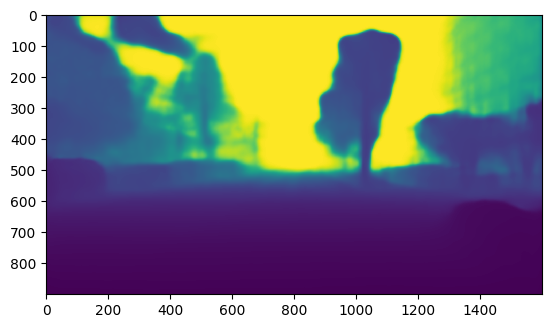

In [11]:
plt.imshow( depth_map )
plt.show()

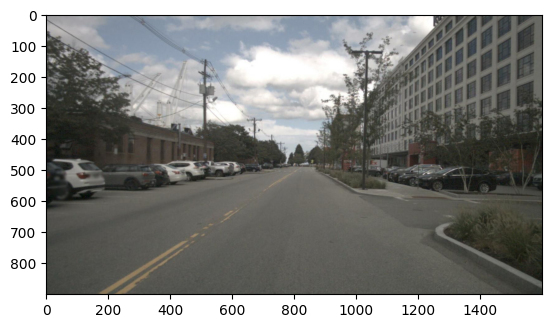

In [12]:
rgb_map=Image.open("/data/nuscenes/nuscenes-full/samples/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.jpg")
rgb_map=np.array(rgb_map)

plt.imshow( rgb_map )
plt.show()



In [13]:
np.max(depth_map)

99.61867704280155

In [14]:
np.min(depth_map)

3.867704280155642

In [ ]:
np.sum(depth_map<4000)

In [ ]:
np.sum(depth_map<22359)

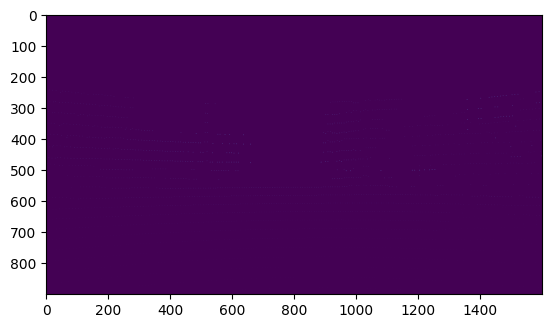

In [15]:

real_depth_map=Image.open("/data/nuscenes/rgbd__image_test/depth/samples/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.png")
real_depth_map=np.array(real_depth_map)/257

plt.imshow( real_depth_map )
plt.show()

In [16]:
np.max(real_depth_map)

87.0

In [17]:
np.min(real_depth_map)

0.0

In [ ]:
# 找到小于24000的像素的索引
indices = np.argwhere(depth_map < 24000)
nbr_rand=20000
# 随机抽取20000个索引
if len(indices) <= nbr_rand:
    # 如果小于4000的像素不足200个，可以选择全部
    selected_indices = indices
else:
    # 否则随机抽取200个
    selected_indices = indices[np.random.choice(len(indices), size=nbr_rand, replace=False)]

# 提取所选像素的深度值
selected_depths = depth_map[selected_indices[:, 0], selected_indices[:, 1]]
# 创建与深度图像相同形状的全零数组
output_array = np.zeros_like(depth_map)

# 将选定的像素深度值复制到输出数组中
for idx in selected_indices:
    row, col = idx
    output_array[row, col] = depth_map[row, col]

In [ ]:
selected_depths.shape

IndexError: index 900 is out of bounds for axis 0 with size 900

In [ ]:
output_array.shape

In [ ]:
plt.imshow(output_array)
plt.show()

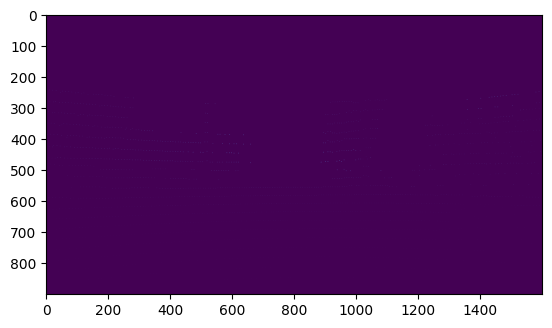

In [21]:
error_map=np.abs(depth_map-real_depth_map)
# 计算误差在15%之内的像素的掩码
error_threshold = 0.5# 15%误差阈值
mask = error_map  <= error_threshold* np.max(real_depth_map)

# 使用掩码选择要显示的像素
result_array = np.zeros_like(depth_map)
result_array[mask] = depth_map[mask]

# 将结果保存为NumPy数组
result_array = result_array.astype(np.uint16)



plt.imshow(result_array)
plt.show()


In [ ]:
# 计算误差在15%之内的像素的掩码
error_threshold = 0.8# 15%误差阈值
mask = error_map  <= error_threshold* np.max(real_depth_map)

# 使用掩码选择要显示的像素
result_array = np.zeros_like(depth_map)
result_array[mask] = depth_map[mask]

# 将结果保存为NumPy数组
process1_map = result_array.astype(np.uint16)



plt.imshow(process1_map)
plt.show()

In [ ]:
nbr_rand=40000
# 随机抽取20000个索引
if len(indices) <= nbr_rand:
    # 如果小于4000的像素不足200个，可以选择全部
    selected_indices = indices
else:
    # 否则随机抽取200个
    selected_indices = indices[np.random.choice(len(indices), size=nbr_rand, replace=False)]

# 提取所选像素的深度值
selected_depths = process1_map[selected_indices[:, 0], selected_indices[:, 1]]
# 创建与深度图像相同形状的全零数组
output_array = np.zeros_like(depth_map)

# 将选定的像素深度值复制到输出数组中
for idx in selected_indices:
    row, col = idx
    output_array[row, col] = process1_map[row, col]
plt.imshow(output_array)
plt.show()

In [ ]:
depth_map_dir="/data/csh_test/vis_out/fsnet1/CAM_FRONT/n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534968255412404.png"
"/data/nuscenes/rgbd__image_test/depth/samples/"+depth_map_dir[30:-3]+"png"




In [ ]:
matrix = np.array([[1, 2, 3, 4],[1, 2, 3, 4],[1, 2, 3, 4]])
matrix.shape

In [ ]:
matrix/[2,2,2,2]